In [144]:
import numpy as np
import matplotlib.pyplot as plt
from geomdl import NURBS
import cadquery as cq
from cadquery import exporters
import math
import os

# ============ GLOBAL BOOLEAN CONTROL PARAMETERS ============
plot_curve_flag   = False  # Whether to plot the 2D NURBS curves for debugging
create_base_flag  = False  # Whether to create a base component
export_base_flag  = False  # If True (and create_base_flag=True), merges final + base into one STL
export_crossSection_flag = True  # If True, exports the cross‐section as a separate STL

# ============ GLOBAL GEOMETRY PARAMETERS ============
n_curves      = 5    # Number of sequential NURBS curves
degree        = 3
order         = degree + 1
knot_c        = 1

# Basic shape & revolve parameters
start_x       = 0
start_y       = 0
cap_height    = 5
cap_length    = 5
thickness     = 1
revolve_offset= thickness

# Example default cross‐section geometry
amplitude0    = 20
period0       = 10
period_values = [period0 * 1, period0 * 1, period0 * 1]

# Control how control‐point midpoints are computed
offset_factor_x0 = 0   # [0, 1]
offset_factor_y0 = 1   # [0, 1]
mid_factor_x      = 0  # [-1 < x < 1]
mid_factor_y      = 0  # [-1 < x < 1]
min_y_positions   = [start_y, 0, 0]  # for descending curves
true_mid          = 1  # 1 => use start/end Y, 0 => relative to midpoint
rel_mid           = 1 - true_mid

# NURBS weighting for the cross‐sections
degree0         = 2
cp1_weight      = 3
cp3_weight      = 3
cp1_weight0     = 3
weights         = [1, cp1_weight, 1, cp3_weight, 1]
weights0        = [1, cp1_weight0, 1]

# Resolution for curve evaluation
resolution = 100

# ============ VALIDATION / PARAMETER COMPUTATION ============

def validate_parameters():
    """Check lengths of min_y_positions, period_values vs n_curves."""
    global n_periods, n_descending_curves, period_values, min_y_positions
    n_periods           = int(np.ceil(n_curves / 2))
    n_descending_curves = int(np.floor(n_curves / 2))

    if len(min_y_positions) < n_descending_curves + 1:
        raise ValueError(f"Length of min_y_positions must be at least {n_descending_curves + 1}")
    elif len(period_values) < n_periods:
        raise ValueError(f"Length of period_values must be at least {n_periods}")
    elif len(min_y_positions) > n_descending_curves + 1:
        # If there are extra min_y_positions, trim and warn
        min_y_positions = min_y_positions[:n_descending_curves + 1]
        print(f"Warning: min_y_positions had extra entries. Trimmed to {len(min_y_positions)}.")
    elif len(period_values) > n_periods:
        # If there are extra period_values, trim and warn
        period_values = period_values[:n_periods]
        print(f"Warning: period_values had extra entries. Trimmed to {len(period_values)}.")

def compute_x_increments_and_y_positions():
    """Compute x‐increments and y‐positions for each curve segment."""
    x_increments = [0] * n_curves
    y_positions  = [0] * (n_curves + 1)
    y_positions[0] = start_y

    p = 0  # period counter
    for i in range(n_curves):
        if i % 2 == 0:  # Ascending
            amplitude        = amplitude0 - min_y_positions[p]
            y_positions[i+1] = y_positions[i] + amplitude
            x_increments[i]  = period_values[p] / 2
        else:            # Descending
            y_positions[i+1] = min_y_positions[p+1]
            x_increments[i]  = period_values[p] / 2
            p += 1
    return x_increments, y_positions

# ============ CURVE GENERATION (CAP + SEQUENTIAL) ============

def generate_cap_curve(start_x, start_y, cap_height, cap_length, weights0, degree0):
    """Generate the initial 'cap' curve at the base of the actuator."""
    all_control_points     = []
    all_curve_points       = []
    control_points_idx     = []
    control_points_idx_names = []
    curve_points_idx       = []
    curve_points_idx_names = []

    # Control points for the initial 'cap' curve
    cp0_x0 = start_x
    cp0_y0 = start_y

    cp1_x0 = cap_length
    cp1_y0 = start_y

    cp2_x0 = cap_length
    cp2_y0 = cap_height

    control_points0 = [
        [cp0_x0, cp0_y0],
        [cp1_x0, cp1_y0],
        [cp2_x0, cp2_y0],
    ]
    all_control_points.append(control_points0)

    curve0_cp_idx = np.arange(1, len(control_points0)+1)
    control_points_idx.append(curve0_cp_idx)
    control_points_idx_names.append(['curve0'])

    curve_weight0 = weights0

    # Construct the knot vector for the cap curve
    order0             = degree0 + 1
    knot_c0            = 1
    no_control_points0 = len(control_points0)
    knot_vector_length0= no_control_points0 + order0
    n0                 = no_control_points0 - 1
    internal_knots0    = n0 - order0 + 1

    if (knot_vector_length0 - 2*order0) >= 0:
        knot_vector0 = ([0]*order0 +
                        [(i*knot_c0) for i in range(1, internal_knots0+1)] +
                        [internal_knots0+1]*order0)
    else:
        raise ValueError("Number of cap control points must be >= degree.")

    # Build the NURBS curve
    curve       = NURBS.Curve()
    curve.degree     = degree0
    curve.ctrlpts    = [[pt[0], pt[1]] for pt in control_points0]
    curve.weights    = curve_weight0
    curve.knotvector = knot_vector0

    # Evaluate & store points
    curve.delta      = 0.01
    curve.evaluate()
    curve_points0    = np.array(curve.evalpts)
    all_curve_points.append(curve_points0[:-1])

    curve0_idx = np.arange(1, len(curve_points0)+1)
    curve_points_idx.append(curve0_idx)
    curve_points_idx_names.append(['curve0']*len(curve_points0))

    end_x0 = curve_points0[-1][0]
    end_y0 = curve_points0[-1][1]

    return (all_control_points, all_curve_points,
            control_points_idx, control_points_idx_names,
            curve_points_idx, curve_points_idx_names,
            end_x0, end_y0)


def generate_curves(x_increments, y_positions,
                    all_control_points, all_curve_points,
                    control_points_idx, control_points_idx_names,
                    curve_points_idx, curve_points_idx_names,
                    end_x0, end_y0):
    """Generate the main sequential NURBS curves after the cap."""
    start_x = end_x0
    for i in range(n_curves):
        # Y start/end
        y_start = end_y0 + y_positions[i]
        y_end   = end_y0 + y_positions[i+1]

        # Polarity
        polarity = np.sign(y_end - y_start)

        # X start/end
        dx = x_increments[i]
        if i < 1:
            x_end = start_x + dx/2
        else:
            x_end = start_x + dx

        # Midpoint
        mid_x = (start_x + x_end)/2
        mid_y = (y_start + y_end)/2

        # Offsets
        offset_factor_x = offset_factor_x0
        offset_factor_y = offset_factor_y0 * polarity

        # Define control points
        if i < 1:
            cp0_x, cp0_y = start_x, y_start
            cp2_x        = cp0_x
        else:
            cp0_x, cp0_y = start_x, y_start
            cp2_x        = mid_x + ((x_end - mid_x)*mid_factor_x)*polarity
        cp2_y            = mid_y + ((x_end - mid_x)*mid_factor_y)*polarity

        if i < 1:
            cp1_x, cp1_y = cp0_x, cp0_y
        else:
            cp1_y = (mid_y*true_mid + cp2_y*rel_mid
                     - abs(y_start - mid_y)*offset_factor_y)
            cp1_x = cp2_x + (x_end - mid_x)*offset_factor_x

        cp3_x = cp2_x - (x_end - mid_x)*offset_factor_x
        cp3_y = (mid_y*true_mid + cp2_y*rel_mid
                 + abs(y_start - mid_y)*offset_factor_y)

        if i < n_curves - 1:
            cp4_x = x_end
        else:
            cp4_x = x_end - thickness
        cp4_y   = y_end

        control_points = [
            [cp0_x, cp0_y],
            [cp1_x, cp1_y],
            [cp2_x, cp2_y],
            [cp3_x, cp3_y],
            [cp4_x, cp4_y]
        ]
        all_control_points.append(control_points)

        # Index arrays
        curve_cp_idx = np.arange(1, len(control_points)+1)
        control_points_idx.append(curve_cp_idx)
        cp_idx_name = [f"curve{i+1}"] * len(control_points)
        control_points_idx_names.append(cp_idx_name)

        # NURBS creation
        no_control_points = len(control_points)
        knot_vector_length= no_control_points + order
        n                = no_control_points - 1
        internal_knots   = n - order + 1

        if (knot_vector_length - 2*order) >= 0:
            knot_vector = (
                [0]*order +
                [(i*knot_c) for i in range(1, internal_knots+1)] +
                [internal_knots+1]*order
            )
        else:
            raise ValueError("Number of control points must be >= degree.")

        curve = NURBS.Curve()
        curve.degree     = degree
        curve.ctrlpts    = [[pt[0], pt[1]] for pt in control_points]
        curve.weights    = weights
        curve.knotvector = knot_vector

        curve.delta = 1/resolution
        curve.evaluate()
        curve_points = np.array(curve.evalpts)

        if i < n_curves - 1:
            all_curve_points.append(curve_points[:-1])
        else:
            all_curve_points.append(curve_points)

        curve_idx = np.arange(1, len(curve_points)+1)
        if i < n_curves - 1:
            curve_points_idx.append(curve_idx[:-1])
        else:
            curve_points_idx.append(curve_idx)

        # Move start_x for the next curve
        start_x = x_end

    return (all_control_points, all_curve_points,
            control_points_idx, control_points_idx_names,
            curve_points_idx, curve_points_idx_names)

def plot_curves(all_control_points, all_curve_points):
    """Optional function to visualize the 2D cross‐section curves & control points."""
    plt.close('all')
    plt.figure(figsize=(10, 6))
    plt.title('Sequential NURBS Curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)

    colors = ['b','g','r','c','m','y','k']

    for i, curve_points in enumerate(all_curve_points):
        color = colors[i % len(colors)]
        plt.plot(curve_points[:,0], curve_points[:,1],
                 label=f'Curve {i+1}', color=color)
        # Control polygon
        control_pts = all_control_points[i]
        cp_x = [pt[0] for pt in control_pts]
        cp_y = [pt[1] for pt in control_pts]
        plt.plot(cp_x, cp_y, 'o--', label=f'Control {i+1}', color=color)

    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.show()

# ============ PRE‐PROCESSING OUTER POINTS & CONTROL POINTS ============

def process_outer_points(all_curve_points):
    """Stack all curve arrays, reverse them, shift so that max_x => x=0, etc."""
    all_points   = np.vstack(all_curve_points)
    outer_points = np.array(all_points)

    # Find max x
    max_x = max(p[0] for p in outer_points)

    # Reverse order
    outer_points = outer_points[::-1]

    # Shift so max_x => x=0
    shifted = []
    for (x,y) in outer_points:
        shifted.append((x - max_x, y))

    outer_points = shifted

    outer_min_x = min(pt[0] for pt in outer_points)
    outer_min_y = min(pt[1] for pt in outer_points)
    outer_max_x = max(pt[0] for pt in outer_points)
    outer_max_y = max(pt[1] for pt in outer_points)
    return outer_points, outer_min_x, outer_min_y, outer_max_x, outer_max_y

def generate_vt_control_points(all_control_points, control_points_idx):
    """
    Based on your existing code, keep only the 'even' indices for variable thickness,
    invert them, shift them. 
    """
    vt_cp_idx = [np.where(np.arange(len(idx)) % 2 == 1, 0, idx) for idx in control_points_idx]
    vt_control_points = []
    for i in range(len(all_control_points)):
        cp_array        = all_control_points[i]
        vt_cp_idx_array = vt_cp_idx[i]
        filtered        = []
        for j in range(len(cp_array)):
            if vt_cp_idx_array[j] != 0:
                filtered.append(cp_array[j])
        vt_control_points.append(filtered)

    # Reverse each sublist and shift so max_x => 0
    vt_control_points = [cp[::-1] for cp in vt_control_points[::-1]]

    max_x = max(pt[0] for cp in vt_control_points for pt in cp)
    out   = []
    for cp in vt_control_points:
        out_cp = [(x - max_x, y) for (x,y) in cp]
        out.append(out_cp)

    return out

# ============ HELPER FUNCTIONS ============

def remove_consecutive_duplicates(points):
    """
    Removes consecutive duplicate points from a list.

    Parameters:
    points (list): A list of points (tuples).

    Returns:
    list: A list with consecutive duplicate points removed.
    """
    if not points:
        return []

    cleaned_points = [points[0]]
    for point in points[1:]:
        if point != cleaned_points[-1]:
            cleaned_points.append(point)
    
    return cleaned_points

def filter_points_by_threshold(points, x_threshold=None, y_threshold=None, x_operator='lt', y_operator='lt'):
    """
    Filters out points based on threshold conditions for x and y coordinates.

    Parameters:
    points (list): List of (x, y) tuples.
    x_threshold (float or None): Threshold value for x coordinate.
    y_threshold (float or None): Threshold value for y coordinate.
    x_operator (str): 'lt' to remove points with x > x_threshold 
                      or 'gt' to remove points with x < x_threshold.
    y_operator (str): 'lt' to remove points with y > y_threshold 
                      or 'gt' to remove points with y < y_threshold.
                      
    Returns:
    list: A list of points meeting the specified conditions.
    """
    filtered = []
    for x, y in points:
        if x_threshold is not None:
            if x_operator == 'lt' and x > x_threshold:
                continue
            elif x_operator == 'gt' and x < x_threshold:
                continue
        if y_threshold is not None:
            if y_operator == 'lt' and y > y_threshold:
                continue
            elif y_operator == 'gt' and y < y_threshold:
                continue
        filtered.append((x, y))
    return filtered

# ============ THICKNESS DISTRIBUTION FUNCTIONS ============

def constant_thickness_distribution(outer_points, thickness_value=1.0):
    """All points => the same thickness."""
    return [thickness_value]*len(outer_points)

def linear_thickness_distribution(outer_points, start_thickness=1.0, end_thickness=2.0):
    """
    Interpolate from start_thickness to end_thickness
    across the entire set of outer_points.
    """
    n_points   = len(outer_points)
    thicknesses= []
    if n_points <= 1:
        return [start_thickness]*(n_points or 1)

    for i in range(n_points):
        t = i/(n_points-1)
        val = start_thickness + t*(end_thickness - start_thickness)
        thicknesses.append(val)
    return thicknesses

def variable_thickness_distribution(outer_points, vt_control_points, all_thicknesses):
    """
    The piecewise interpolation approach from your original code,
    factoring out control_points_idx logic, etc.
    This code expects that:
      - all_thicknesses is an array of arrays that define thickness segments.
      - We do the 'closest point' mapping from vt_control_points to outer_points indices
        and then fill in the thickness piecewise.
    """
    import math

    # Flatten vt_control_points
    vt_cp_array = np.vstack(vt_control_points)
    cp_in_curve_idx = []

    # Find index of closest outer_point for each vt_control_point
    for (x_cp, y_cp) in vt_cp_array:
        distances = [math.hypot(x_cp - x_o, y_cp - y_o) for (x_o,y_o) in outer_points]
        idx       = distances.index(min(distances))
        cp_in_curve_idx.append(idx)

    # Check first & last
    if cp_in_curve_idx[0] != 0 or cp_in_curve_idx[-1] != len(outer_points)-1:
        raise ValueError("First control point must map to 0 and last must map to len(outer_points)-1")

    # Segment them according to vt_control_points
    # We assume each sublist in vt_control_points has consistent length with all_thicknesses
    seg_indices = []
    start_idx   = 0
    for segment in vt_control_points:
        seg_len = len(segment)
        seg     = cp_in_curve_idx[start_idx : start_idx+seg_len]
        # remove duplicates
        unique  = []
        for x in seg:
            if x not in unique:
                unique.append(x)
        seg_indices.append(unique)
        start_idx += seg_len

    # Now do the piecewise interpolation
    point_thicknesses = []
    # 'all_thicknesses' is presumably reversed to match the reversed segments. 
    # We'll assume you handle that outside or you store them in the correct order.
    for i, seg_idx in enumerate(seg_indices):
        thickness_vals = all_thicknesses[i]  # e.g. [1, 0.5, 1]
        for j in range(len(seg_idx)-1):
            start_t = thickness_vals[j]
            end_t   = thickness_vals[j+1]

            idx_start = seg_idx[j]
            idx_end   = seg_idx[j+1]
            n         = idx_end - idx_start

            for k in range(n):
                frac   = k/n
                interp = start_t + frac*(end_t - start_t)
                point_thicknesses.append(interp)

        # Append final thickness in that segment
        point_thicknesses.append(thickness_vals[-1])

    return point_thicknesses

def apply_thickness(
    outer_points,
    mode="variable",
    vt_control_points=None,
    all_thicknesses=None,
    constant_value=1.0,
    linear_start=1.0,
    linear_end=2.0
):
    """
    Main dispatcher that returns a thickness array for each point in outer_points
    according to the chosen mode:

      mode = "constant" => constant_thickness_distribution
      mode = "linear"   => linear_thickness_distribution
      mode = "variable" => variable_thickness_distribution

    For 'variable', you must supply vt_control_points & all_thicknesses
    """
    if mode == "constant":
        return constant_thickness_distribution(outer_points, constant_value)

    elif mode == "linear":
        return linear_thickness_distribution(outer_points, linear_start, linear_end)

    elif mode == "variable":
        if vt_control_points is None or all_thicknesses is None:
            raise ValueError("For variable mode, provide vt_control_points and all_thicknesses.")
        return variable_thickness_distribution(outer_points, vt_control_points, all_thicknesses)

    else:
        raise ValueError(f"Unknown thickness mode: {mode}")

# ============ BUILDING INNER PROFILE & 3D MODEL ============

def calculate_normals(outer_points):
    """
    For each consecutive pair of points, compute normal by rotating the tangent 90 deg.
    Duplicates the last normal for the final point.
    """
    tangents = []
    normals  = []
    for i in range(len(outer_points)-1):
        x1, y1 = outer_points[i]
        x2, y2 = outer_points[i+1]
        dx = x2 - x1
        dy = y2 - y1
        length = math.hypot(dx, dy) or 1e-8
        tx = dx/length
        ty = dy/length
        tangents.append((tx, ty))

        # Normal is tangent rotated by +90 deg
        nx = -ty
        ny = tx
        normals.append((nx, ny))

    # Duplicate last normal
    if len(normals) > 0:
        normals.append(normals[-1])
    else:
        # if there's only 1 or 0 points, handle corner case
        normals = [(1,0)]

    return normals

# def generate_inner_profile(outer_points, normals, point_thicknesses, outer_min_x, outer_max_x):
#     """
#     Offsets each point inward by the thickness along the normal.
#     Skips any offset that goes out of [outer_min_x, outer_max_x].
#     """
#     inner_points = []
#     for i, (x_o, y_o) in enumerate(outer_points):
#         nx, ny   = normals[i]
#         t        = point_thicknesses[i]
#         x_in     = x_o + nx * t
#         y_in     = y_o + ny * t

#         # Optional bounds check
#         if (x_in > outer_min_x) and (x_in < outer_max_x):
#             inner_points.append((x_in, y_in))
#         else:
#             # Could skip or clamp
#             continue

#     return inner_points

from shapely.geometry import Point, MultiPolygon
from shapely.ops import unary_union

def generate_inner_profile(outer_points, thicknesses):
    """
    Instead of manually offsetting by normals, we:
      1) For each (x_i, y_i), create a circle with radius = thicknesses[i].
      2) Pairwise union those circles + take the convex hull => 'capsule'.
      3) Union all capsules into one final shape.
    Then we extract that shape's exterior coords as "inner_points".

    Inputs:
      outer_points : list of (x,y) along your curve
      thicknesses  : list of radial distances at each point
    Returns:
      A list of (x,y) that forms the boundary of the unioned shape. 
      We can revolve or use in your cross‐section pipeline.

    NOTE: This approach focuses on "circles at each vertex." If your shape has
          large edges or you want the entire line buffered, you may also 
          want to do line buffering and union with the circles.
    """
    # import shapely

    # 1) Build circle buffers at each point
    #    E.g. point_buffers[i] = shapely.Point(outer_points[i]).buffer(thicknesses[i])
    point_buffers = []
    for (x,y), r in zip(outer_points, thicknesses):
        circle = Point(x, y).buffer(r, resolution=32) 
        # 'resolution=32' => how many segments approximate the circle
        point_buffers.append(circle)

    # 2) For each pair of consecutive circles, build a "capsule" by union + convex hull
    capsules = []
    for i in range(len(point_buffers) - 1):
        unioned = point_buffers[i].union(point_buffers[i+1])
        cap     = unioned.convex_hull
        capsules.append(cap)

    # If you want end circles too, you might union them as well:
    # capsules += [point_buffers[0], point_buffers[-1]]

    # 3) Union ALL capsules
    if len(capsules) == 0:
        # fallback if there's only one or zero points
        # (then just return the single circle or empty)
        if len(point_buffers) == 1:
            final_shape = point_buffers[0]
        else:
            final_shape = None
    else:
        final_shape = unary_union(capsules)

    if final_shape is None:
        return []

    # 4) Extract the boundary as a list of coordinates
    # final_shape might be a Polygon, MultiPolygon, etc.
    if final_shape.geom_type == "Polygon":
        exterior_coords = list(final_shape.exterior.coords)
        return exterior_coords
    elif final_shape.geom_type == "MultiPolygon":
        # pick the largest polygon, or combine, etc.
        # here we just pick the biggest by area:
        biggest = max(final_shape.geoms, key=lambda g: g.area)
        exterior_coords = list(biggest.exterior.coords)
        return exterior_coords
    else:
        # Possibly a LineString or empty
        return []

def shift_and_close(coords):
    if not coords:
        return []

    coords = coords[::-1]

    first_x, first_y = coords[0]
    shifted = [(x, y) for (x,y) in coords]
    # shifted = [((x - first_x), y for (x,y) in coords]
    # optionally close
    if shifted[-1] != shifted[0]:
        shifted.append(shifted[0])
    return shifted

def generate_cross_section(outer_points, inner_points):
    """
    Combine inner_points + reversed outer_points into a single closed polyline.
    Then shift so the first point => (0,0).
    """
    outer_list = [tuple(pt) for pt in outer_points]
    inner_list = [tuple(pt) for pt in inner_points]

    inverted_outer = outer_list[::-1]

    cross_section_points = inner_list + inverted_outer
    # close the profile
    cross_section_points.append(cross_section_points[0])

    # shift so cross_section_points[0] => (0,0)
    first_x, first_y = cross_section_points[0]
    shifted = [(x - first_x, y) for (x,y) in cross_section_points]
    return shifted

def create_2d_cross_section(cross_section_points):
    """
    Create a 2D cross‐section from the combined inner/outer points.
    """
    twoD_cross_section = (cq.Workplane("XY")
               .polyline(cross_section_points)
               .close()
               .extrude(0.1)
              )
    return twoD_cross_section

def create_3d_model(cross_section_points, outer_max_y):
    """
    Revolve the 2D cross_section around the Y axis to form the actuator body,
    then add a top 'cap'.
    """
    profile = (cq.Workplane("XY")
               .polyline(cross_section_points)
               .close()
               .edges()
               .revolve(angleDegrees=360,
                        axisStart=(revolve_offset,0,0),
                        axisEnd=(revolve_offset,1,0))
               .translate((-revolve_offset,0,0))
              )

    # Simple top cap
    cap_thickness = 1
    cap = (cq.Workplane("XZ")
           .circle(revolve_offset)
           .extrude(cap_thickness)
           .translate((0, outer_max_y, 0))
          )

    final = profile + cap
    return final

# ============ BASE (OPTIONAL) + EXPORT ============

def create_base(outer_max_x, outer_min_x, outer_max_y):
    """
    Creates a base with holes, clamp geometry, etc.
    Adjust as needed.
    """
    base_extension     = cap_length * 2
    base_radius        = abs(outer_max_x - outer_min_x) + revolve_offset + thickness + base_extension
    base_internal_radius = base_radius - base_extension - cap_length - revolve_offset - thickness
    base_plate_height  = 2
    base_internal_height= cap_height - thickness
    height_factor      = 0.8
    base_input_radius  = 7.625
    wall_thickness     = 3

    screw_radius       = 3/2
    screw_head_radius  = 5.5/2
    screw_tolerance    = screw_head_radius * 2
    outer_screw_tolerance = screw_head_radius
    desired_diameter   = 2*base_radius - 2*(screw_tolerance/2 + outer_screw_tolerance)
    desired_side_length= desired_diameter/np.sqrt(2)

    clamp_side_length = 30
    clamp_depth       = 30

    base0 = (cq.Workplane("XZ")
        .circle(base_radius)
        .extrude(base_plate_height)
        .translate((0, -base_internal_height, 0))
        # Add screw holes
        .faces(">Y")
        .rect(desired_side_length, desired_side_length, forConstruction=True)
        .vertices()
        .circle(screw_radius)
        .cutThruAll()
        # Internal base plate
        .faces(">Y")
        .workplane()
        .circle(base_internal_radius)
        .extrude(base_internal_height * height_factor)
        # The clamp
        .faces("<Y")
        .workplane()
        .rect(clamp_side_length, clamp_side_length)
        .extrude(clamp_depth, combine=True)
        # The input hole
        .faces("<Y")
        .workplane()
        .circle(base_input_radius)
        .cutThruAll()
        # Hollow walls
        .faces(">Y")
        .workplane()
        .circle(base_internal_radius - wall_thickness)
        .extrude(-base_internal_height, combine='cut')
    )

    base1 = (cq.Workplane("XZ")
        .circle(base_radius)
        .extrude(base_plate_height)
        # Screw holes
        .faces(">Y")
        .rect(desired_side_length, desired_side_length, forConstruction=True)
        .vertices()
        .circle(screw_radius)
        .cutThruAll()
        # Hollow the plate
        .faces(">Y")
        .workplane()
        .circle(base_internal_radius + thickness)
        .extrude(-base_plate_height, combine='cut')
        .translate((0, -(base_internal_height - base_plate_height - thickness) + 2, 0))
    )

    base = base0 + base1
    return base

def create_2d_crossSection(cross_section_points):
    """
    Create a 2D cross‐section from the combined inner/outer points.
    """
    twoD_cross_section = (cq.Workplane("XY")
               .polyline(cross_section_points)
               .close()
              )
    
    return twoD_cross_section

def create_3d_crossSection(cross_section_points, outer_max_y):
    """
    Revolve the 2D cross_section 180 degrees around the Y axis to form the actuator body,
    then add a top 'cap'.
    """
    profile = (cq.Workplane("XY")
               .polyline(cross_section_points)
               .close()
               .edges()
               .revolve(angleDegrees=180,
                        axisStart=(revolve_offset,0,0),
                        axisEnd=(revolve_offset,1,0))
               .translate((-revolve_offset,0,0))
              )

    # Simple top cap
    cap_thickness = 1
    cap = (cq.Workplane("XZ")
           .circle(revolve_offset)
           .extrude(cap_thickness)
           .translate((0, outer_max_y, 0))
          )

    threeD_cross_section = profile + cap

    return threeD_cross_section

def export(model, title, export_type='stl', directory=None, overwrite=False):
    """
    Exports the given model to a file in the specified format with the given title.

    Parameters:
    - model: The 3D model object to be exported. It must have an 'export' method.
    - title (str): The desired name for the exported file (without the extension).
    - export_type (str, optional): The format to export the model. Supported types include 'stl', 'step', 'dxf'.
                                   Defaults to 'stl'.
    - directory (str, optional): The directory where the file will be saved.
                                 Defaults to the current script's directory.
    - overwrite (bool, optional): If True, existing files with the same name will be overwritten without confirmation.
                                  Defaults to False.

    Supported Export Types:
    - 'stl'  : Stereolithography
    - 'step' : STEP (Standard for the Exchange of Product Data)
    - 'dxf'  : Drawing Exchange Format

    Example:
    export(model_obj, "custom_model_name", export_type="step", directory="/path/to/save", overwrite=True)
    """

    # Define supported export types and their corresponding file extensions
    supported_types = {
        'stl': '.stl',
        'step': '.step',
        'dxf': '.dxf'
    }

    # Normalize the export_type to lowercase to ensure case-insensitive matching
    export_type = export_type.lower()

    # Validate the export_type
    if export_type not in supported_types:
        print(f"Error: Unsupported export type '{export_type}'. Supported types are: {', '.join(supported_types.keys())}.")
        return

    # Ensure the title does not already end with the correct extension
    extension = supported_types[export_type]
    if title.lower().endswith(extension):
        title = title[:-len(extension)]

    # Construct the filename by appending the appropriate extension
    filename = f"{title}{extension}"

    # Determine the default directory if none is provided
    if directory is None:
        try:
            # Get the absolute path of the current script
            directory = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            # __file__ is not defined (e.g., in interactive sessions), fallback to current working directory
            directory = os.getcwd()

    # If a directory is specified, ensure it exists
    if directory:
        if not os.path.isdir(directory):
            try:
                os.makedirs(directory)
                print(f"Directory '{directory}' created as it did not exist.")
            except Exception as e:
                print(f"Error: Unable to create directory '{directory}'. Details: {e}")
                return
        filepath = os.path.join(directory, filename)
    else:
        filepath = filename  # Save in the current working directory

    # Check if the file already exists
    if os.path.exists(filepath) and not overwrite:
        response = input(f"File '{filepath}' already exists. Overwrite? (y/n): ").lower()
        if response != 'y':
            print("Export canceled by the user.")
            return

    try:
        # Export the model to the specified filepath
        model.export(filepath)
        print(f"Model exported as '{filepath}'")
    except AttributeError:
        print("Error: The provided model does not have an 'export' method.")
    except IOError as e:
        print(f"IOError: Failed to write to file '{filepath}'. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")



def combine(final_obj, base_obj):
    combined = final_obj + base_obj

    return combined

def export_model(final_obj):
    final_obj.export("final_model.stl")
    print("Model exported as 'final_model.stl'")




In [145]:
# ============ MAIN ============

# Choose your thickness mode
thickness_mode = "variable"  # "constant", "linear", or "variable"

# Baseline Thickness value [mm]
thickness_value = 1.0

# If "Constant", define:
constant_thickness = thickness_value

# If 'linear', define:
linear_start = 1.0
linear_end   = 3.0

# If 'variable', define:
# These are thickness factors where setting 1 defines local thickness = thickness value.
thickness_factors = [
    [1, 1],          # For cap curve (curve0)
    [1, 0.5, 1],     # curve1
    [1, 0.5, 1],     # curve2
    [1, 0.5, 1],     # curve3
    [1, 0.5, 1],     # curve4
    [1, 0.5, 1],     # curve5
]
# Multiply each factor by the baseline thickness value
thickness_factors = [[value * thickness_value for value in sublist] for sublist in thickness_factors]

# Reverse them to match existing logic
thickness_factors = [t[::-1] for t in thickness_factors[::-1]]

# =========== Geometry Generation ===========
validate_parameters()
x_increments, y_positions = compute_x_increments_and_y_positions()


# 1) Cap Curve
(all_control_points, all_curve_points,
    control_points_idx, control_points_idx_names,
    curve_points_idx, curve_points_idx_names,
    end_x0, end_y0
) = generate_cap_curve(
    start_x, start_y,
    cap_height, cap_length,
    weights0, degree0
)

# 2) Generate the main curves
(all_control_points, all_curve_points,
    control_points_idx, control_points_idx_names,
    curve_points_idx, curve_points_idx_names
) = generate_curves(x_increments, y_positions,
                    all_control_points, all_curve_points,
                    control_points_idx, control_points_idx_names,
                    curve_points_idx, curve_points_idx_names,
                    end_x0, end_y0)

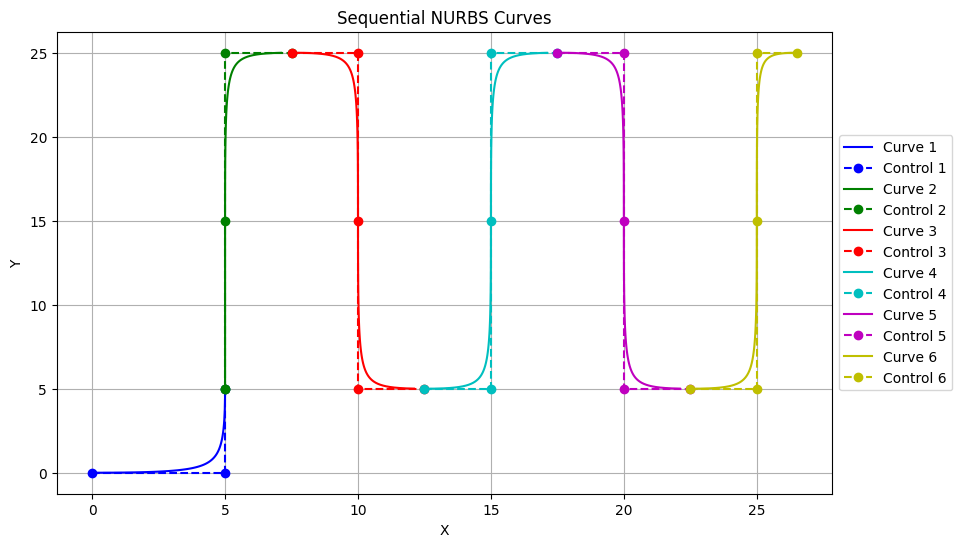

In [146]:
# if plot_curve_flag:
#     plot_curves(all_control_points, all_curve_points)

plot_curves(all_control_points, all_curve_points)

In [147]:
# 3) Process outer points
outer_points, outer_min_x, outer_min_y, outer_max_x, outer_max_y = process_outer_points(all_curve_points)

# 4) For the variable approach, we need vt_control_points 
vt_control_points = generate_vt_control_points(all_control_points, control_points_idx)

# 5) Calculate normals
normals = calculate_normals(outer_points)

# 6) Apply thickness
point_thicknesses = apply_thickness(
    outer_points=outer_points,
    mode=thickness_mode,
    vt_control_points=vt_control_points,
    all_thicknesses=thickness_factors,
    constant_value=constant_thickness,
    linear_start=linear_start,
    linear_end=linear_end
)

In [148]:
# Check points and max/min values
print(outer_max_x)
print(outer_min_x)
print(outer_max_y)
print(outer_min_y)

0.0
-26.5
25.0
0.0


In [161]:
import pandas as pd
from IPython.display import display, HTML

# need to first reverse outer_points
# outer_points = outer_points[::-1]

# 7) Build inner profile
inner_points = generate_inner_profile(outer_points, point_thicknesses)

inner_points_filtered = filter_points_by_threshold(inner_points, x_threshold=outer_max_x, x_operator='lt')
inner_points_filtered = filter_points_by_threshold(inner_points_filtered, x_threshold=outer_min_x, x_operator='gt')

# cross_section_points = shift_and_close(inner_points_filtered)

print(inner_points_filtered)

# # Assuming cross_section_points is a list of (x, y) tuples
# df = pd.DataFrame(outer_points, columns=["X", "Y"])
# html_table = df.to_html(index=False)
# display(HTML(f'<div style="max-height: 300px; overflow-y: auto;">{html_table}</div>'))

[(-26.5, 1.0), (-26.450932325672582, 0.9987954562051724), (-26.162509245011403, 0.9890941985542642), (-25.89979226780995, 0.9803027708052343), (-25.659500954443306, 0.9723285485315262), (-25.43889039219177, 0.9650948082862831), (-25.235646205633845, 0.9585376429591169), (-25.047803335116928, 0.9526035771149316), (-24.873682534038043, 0.9472477042606012), (-24.711840233494556, 0.9424322179660802), (-24.561028602773636, 0.9381252435013255), (-24.420163465929168, 0.9342999011373668), (-24.308992639384616, 0.9314618495170016), (-24.207662588538312, 0.9290642206657292), (-24.09090590625657, 0.9265496291699612), (-23.980942242977818, 0.9244459269869614), (-23.87719830200121, 0.9227422927934059), (-23.77916363395752, 0.9214299893185621), (-23.686382259218313, 0.9205021281452687), (-23.598445595854923, 0.9199534736174263), (-23.51498646180971, 0.9197802790910458), (-23.435673965634887, 0.9199801501147571), (-23.36020913593836, 0.9205519301831905), (-23.28832116788321, 0.9214956055414867), (-23

In [150]:
# 8) Cross‐section
# cross_section_points = generate_cross_section(outer_points, inner_points)


In [151]:
# # Optional: Export the cross‐section
# if export_crossSection_flag:
#     twoD_cross_section = create_2d_crossSection(cross_section_points)
#     threeD_cross_section = create_3d_crossSection(cross_section_points, outer_max_y)
#     export(twoD_cross_section, "cross_section_2D")
#     export(threeD_cross_section, "cross_section_3D")

In [152]:
twoD_cross_section = create_2d_crossSection(cross_section_points)
twoD_cross_section.export("cross_section_2D.stl")

In [153]:
threeD_cross_section = create_3d_crossSection(cross_section_points, outer_max_y)

Standard_Failure: BRepAdaptor_Curve::No geometry

In [141]:
# 9) Create 3D model
# final = create_3d_model(cross_section_points, outer_max_y)

In [142]:
# # Optional: Base creation
# if create_base_flag:
#     base = create_base(outer_max_x, outer_min_x, outer_max_y)

# base = create_base(outer_max_x, outer_min_x, outer_max_y)

In [143]:
# # Export Final Model
# if export_base_flag and create_base_flag:
#     combined = combine(final, base)
#     export(combined, "final_model_combined")
# else:
#     export(final, "final_model")
